In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from transformers import get_scheduler
from transformers import XLMRobertaModel
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support, classification_report
import os

c:\Users\arnab\miniconda3\envs\emotion-detection\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
text_data=torch.load("../datasets/processed_text/augmented_text_data.pt")

input_ids = text_data['input_ids']
attention_mask = text_data['attention_mask']
labels = text_data['labels']

In [3]:
print(set(labels))  # Should ONLY be {'Angry', 'Sad', 'Neutral', 'Suprised', 'Happy'}

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

{'Angry', 'Suprised', 'Happy', 'Neutral', 'Sad'}


In [4]:
labels = np.array(labels)

print("Labels with None: ", np,sum([x is None for x in labels]))
print("Labels with NaN: ", np.sum(pd.isnull(labels)))

valid_idx=[i for i, x in enumerate(labels) if x is not None and not pd.isnull(x)]
input_ids = input_ids[valid_idx]
attention_mask = attention_mask[valid_idx]
labels = labels[valid_idx]

print(labels)

Labels with None:  <module 'numpy' from 'c:\\Users\\arnab\\miniconda3\\envs\\emotion-detection\\lib\\site-packages\\numpy\\__init__.py'> 0
Labels with NaN:  0
['Neutral' 'Suprised' 'Happy' ... 'Sad' 'Suprised' 'Neutral']


In [5]:
  
emotion2id = {
    "Angry": 0,
    "Sad": 1,
    "Neutral": 2,
    "Suprised": 3,
    "Happy": 4
}
    
numeric_labels = [emotion2id[label] for label in labels]

print(set(numeric_labels))  # Should be exactly {0, 1, 2, 3, 4}
print(max(numeric_labels))  # Should be 4
print(min(numeric_labels))  # Should be 0

labels=torch.tensor(numeric_labels, dtype=torch.long)

print(labels)

{0, 1, 2, 3, 4}
4
0
tensor([2, 3, 4,  ..., 1, 3, 2])


In [6]:
train_idx, val_idx=train_test_split(list(range(len(labels))),test_size=0.1, random_state=42, stratify=labels)

train_dataset= TensorDataset(
    input_ids[train_idx],
    attention_mask[train_idx],
    labels[train_idx]
)

val_dataset= TensorDataset(
    input_ids[val_idx],
    attention_mask[val_idx],
    labels[val_idx]
)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)



In [7]:
label_counts=torch.tensor([1461, 637, 937, 1067, 1015], dtype=torch.float)
class_weights=1.0/label_counts
class_weights=class_weights / class_weights.sum()
class_weights=class_weights.to(device)

sample_weights= class_weights[labels[train_idx]]

sampler=WeightedRandomSampler(
    weights=sample_weights, num_samples=len(sample_weights), replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, sampler=sampler, num_workers=4, pin_memory=True)

In [8]:
class EmotionClassifier(torch.nn.Module):
    def __init__(self, dropout=0.3, num_classes=5):
        super(EmotionClassifier, self).__init__()
        self.base_model = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        self.dropout=nn.Dropout(dropout)
        self.norm=nn.LayerNorm(self.base_model.config.hidden_size)
        self.out=nn.Linear(self.base_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output=torch.mean(outputs.last_hidden_state, dim=1)
        x=self.dropout(self.norm(pooled_output))
        return self.out(x)

In [9]:
num_labels=len(emotion2id)

model = EmotionClassifier(num_classes=len(emotion2id)).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)


c:\Users\arnab\miniconda3\envs\emotion-detection\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\arnab\miniconda3\envs\emotion-detection\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
labels = torch.tensor(numeric_labels, dtype=torch.long)


In [11]:
def label_smoothening_loss(outputs, target, smoothing=0.1):
    n_classes=outputs.size(1)
    one_hot = torch.zeros_like(outputs).scatter(1, target.unsqueeze(1), 1)
    one_hot = one_hot * (1 - smoothing) + (smoothing / n_classes)
    log_probs = F.log_softmax(outputs, dim=-1)
    loss = -(one_hot * log_probs).sum(dim=1).mean()
    return loss

In [12]:
epochs = 20

In [13]:
get_scheduler=get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs
)

In [14]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for batch in train_loader:
        input_ids_batch, attention_mask_batch, labels_batch = [x.to(device) for x in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
        logits= outputs

        #1)  label smoothening loss
        #loss = label_smoothening_loss(logits, labels_batch, smoothing=0.1)
        #2)  cross entropy loss
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(logits, labels_batch)
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        get_scheduler.step()
        running_loss += loss.item()*input_ids.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids_batch, attention_mask_batch, labels_batch = [x.to(device) for x in batch]
            outputs=model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
            preds=torch.argmax(outputs, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    acc=np.mean(np.array(all_preds) == np.array(all_labels))
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {acc:.4f}")
    print(f"Epoch {epoch+1}/{epochs}, Validation F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Epoch 1/20, Loss: 396.3554, Validation Accuracy: 0.5752
Epoch 1/20, Validation F1-score: 0.5845, Precision: 0.6131, Recall: 0.5752
Epoch 2/20, Loss: 243.1651, Validation Accuracy: 0.6016
Epoch 2/20, Validation F1-score: 0.6037, Precision: 0.6370, Recall: 0.6016
Epoch 3/20, Loss: 169.6450, Validation Accuracy: 0.6057
Epoch 3/20, Validation F1-score: 0.6065, Precision: 0.6247, Recall: 0.6057
Epoch 4/20, Loss: 118.2166, Validation Accuracy: 0.5996
Epoch 4/20, Validation F1-score: 0.6073, Precision: 0.6234, Recall: 0.5996
Epoch 5/20, Loss: 85.8732, Validation Accuracy: 0.6016
Epoch 5/20, Validation F1-score: 0.6080, Precision: 0.6291, Recall: 0.6016
Epoch 6/20, Loss: 60.2123, Validation Accuracy: 0.6382
Epoch 6/20, Validation F1-score: 0.6373, Precision: 0.6424, Recall: 0.6382
Epoch 7/20, Loss: 45.1441, Validation Accuracy: 0.6098
Epoch 7/20, Validation F1-score: 0.6123, Precision: 0.6181, Recall: 0.6098
Epoch 8/20, Loss: 35.7174, Validation Accuracy: 0.6321
Epoch 8/20, Validation F1-score

Labels in preds: {0, 1, 2, 3, 4}
Labels in true: {0, 1, 2, 3, 4}
Class names: {'Angry': 0, 'Sad': 1, 'Neutral': 2, 'Suprised': 3, 'Happy': 4}
Confusion matrix shape: (5, 5)


<Figure size 800x600 with 0 Axes>

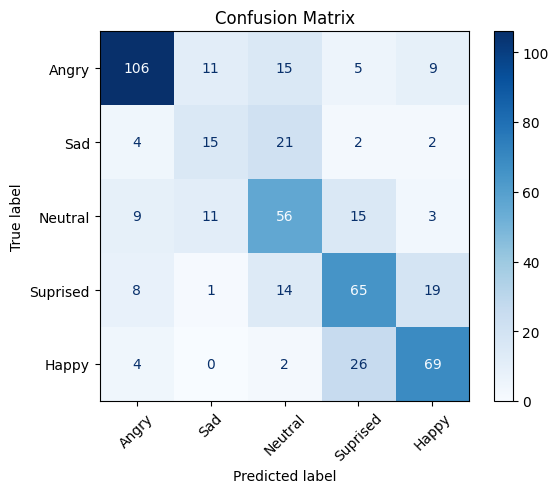

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids_batch = batch[0].to(device)
        attention_mask_batch = batch[1].to(device)
        labels_batch = batch[2].to(device)

        outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
        logits = outputs
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotion2id.keys()))


print("Labels in preds:", set(all_preds))
print("Labels in true:", set(all_labels))
print("Class names:", emotion2id)
print("Confusion matrix shape:", cm.shape)

# Plot it
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()




In [16]:
from collections import Counter
print(Counter(labels.numpy()))


Counter({0: 1461, 3: 1067, 4: 1015, 2: 937, 1: 437})


In [17]:
from collections import Counter
print(Counter(all_preds))


Counter({0: 131, 3: 113, 2: 108, 4: 102, 1: 38})


In [18]:
from collections import Counter
val_labels = labels[val_idx]
print(Counter(val_labels.tolist()))


Counter({0: 146, 3: 107, 4: 101, 2: 94, 1: 44})


In [19]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=list(emotion2id.keys())))


              precision    recall  f1-score   support

       Angry       0.81      0.73      0.77       146
         Sad       0.39      0.34      0.37        44
     Neutral       0.52      0.60      0.55        94
    Suprised       0.58      0.61      0.59       107
       Happy       0.68      0.68      0.68       101

    accuracy                           0.63       492
   macro avg       0.59      0.59      0.59       492
weighted avg       0.64      0.63      0.63       492



In [20]:
torch.save(model.state_dict(), "models/xlm_roberta_emotion_augmented.pt")


In [15]:
model= EmotionClassifier(num_classes=len(emotion2id)).to(device)
model.load_state_dict(torch.load("models/xlm_roberta_emotion_augmented.pt", map_location=device))
model.eval()

all_probs=[]

with torch.no_grad():
    for batch in val_loader:
        input_ids_batch, attention_mask_batch, labels_batch = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
        probs = F.softmax(outputs, dim=-1)
        all_probs.append(probs.cpu())

text_val_probs =torch.cat(all_probs, dim=0)
text_preds=text_val_probs.argmax(dim=-1)


c:\Users\arnab\miniconda3\envs\emotion-detection\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [16]:
os.makedirs("../datasets/fusion", exist_ok=True)
torch.save(text_val_probs, "../datasets/fusion/text_val_probs.pt")
print("Saved: text_val_probs.pt")
torch.save(text_preds, "../datasets/fusion/text_val_preds.pt")
print("Saved: text_val_preds.pt")

Saved: text_val_probs.pt
Saved: text_val_preds.pt
